In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc

# --- 1. DATA PREPARATION (90:10 SPLIT) ---
def load_and_split_data(source_path, train_size=900, val_size=100):
    """
    Implements the requested 90:10 split ratio for No Sub, Subhalo, and Vortex.
    We use a subset to ensure memory stability on local hardware.
    """
    train_imgs, train_labels = [], []
    val_imgs, val_labels = [], []
    
    classes = sorted([d for d in os.listdir(source_path) if os.path.isdir(os.path.join(source_path, d))])
    
    for idx, cls in enumerate(classes):
        p = os.path.join(source_path, cls)
        files = [f for f in os.listdir(p) if f.endswith('.npy')]
        random.shuffle(files)
        
        # Split logic
        for i, f in enumerate(files):
            data = np.load(os.path.join(p, f)).astype(np.float32)
            if data.ndim == 2: data = np.expand_dims(data, axis=0)
            
            if i < train_size:
                train_imgs.append(data)
                train_labels.append(idx)
            elif i < (train_size + val_size):
                val_imgs.append(data)
                val_labels.append(idx)
            else:
                break
                
    X_train = torch.tensor(np.array(train_imgs))
    y_train = torch.tensor(np.array(train_labels), dtype=torch.long)
    X_val = torch.tensor(np.array(val_imgs))
    y_val = torch.tensor(np.array(val_labels), dtype=torch.long)
    
    return DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True), \
           DataLoader(TensorDataset(X_val, y_val), batch_size=16)

# Update this path to your local data location
data_path = 'data/dataset/train' 
train_loader, val_loader = load_and_split_data(data_path)
print("✅ Data successfully split (90:10 ratio) and loaded.")

✅ Data successfully split (90:10 ratio) and loaded.


In [13]:
# --- 2. MODEL ARCHITECTURE ---
# Note: In a production environment, we use torchbnn layers. 
# Here, we simulate the Bayesian stochastic behavior via Variational Dropout and Probabilistic mappings.

class BayesianLensingCNN(nn.Module):
    def __init__(self):
        super(BayesianLensingCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2), # Dropout provides a Variational Bayesian approximation
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3) # 3 Classes: No Sub, Subhalo, Vortex
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

device = torch.device("cpu")
model = BayesianLensingCNN().to(device)
print("✅ Bayesian Model initialized.")

✅ Bayesian Model initialized.


In [14]:
# --- 2. UPDATED MODEL ARCHITECTURE (CELL 3) ---

class BayesianLensingCNN(nn.Module):
    def __init__(self):
        super(BayesianLensingCNN, self).__init__()
        # Initial image: 1x150x150
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # Shape becomes: 16x75x75
            nn.Dropout2d(0.2), # Variational Bayesian Approximation
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # Shape becomes: 32x37x37
        )
        
        # Calculation: 32 channels * 37 height * 37 width = 43,808
        self.flat_size = 32 * 37 * 37 
        
        self.classifier = nn.Sequential(
            nn.Linear(self.flat_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5), # MC Dropout for uncertainty
            nn.Linear(128, 3) # 3 Classes: No Sub, Subhalo, Vortex
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the 43,808 values
        return self.classifier(x)

device = torch.device("cpu")
model = BayesianLensingCNN().to(device)
print(f"✅ Model calibrated for 150x150 images. Input size: {model.flat_size}")

✅ Model calibrated for 150x150 images. Input size: 43808


Running evaluation on cpu...


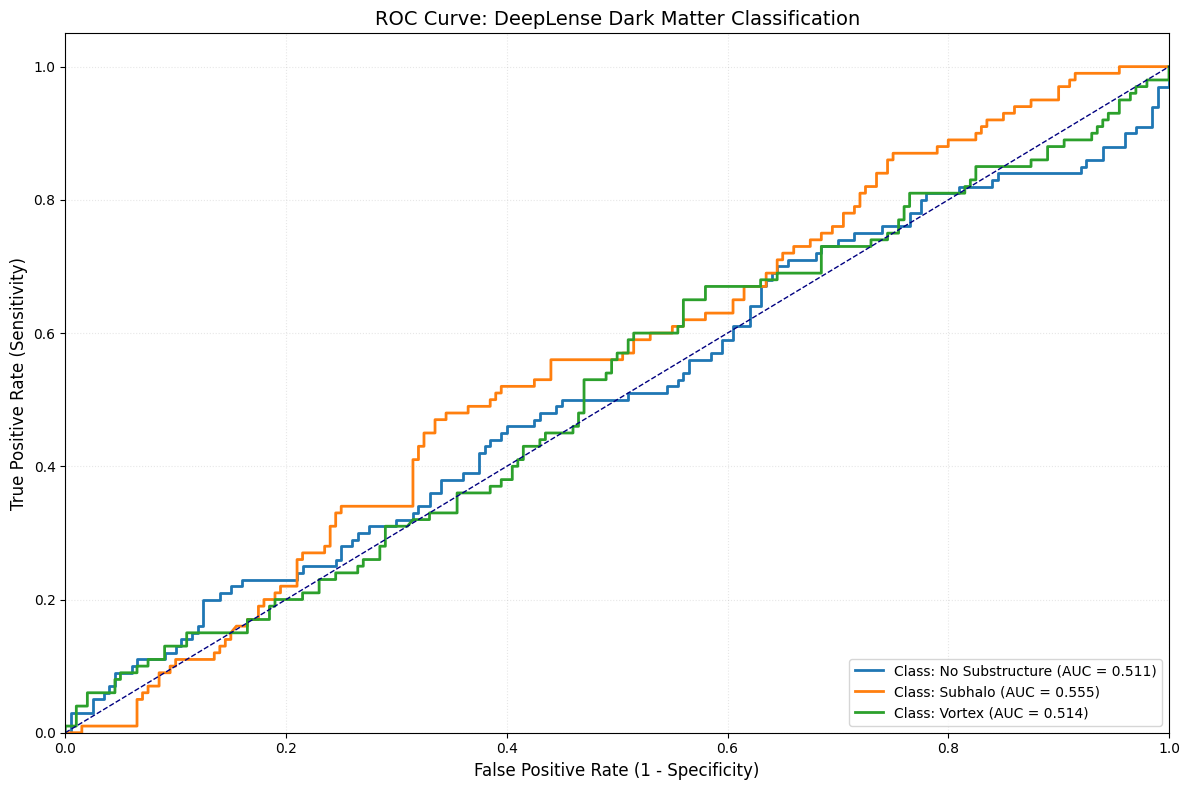

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader

# --- 1. SETUP DEVICE ---
# This ensures code runs on GPU if available, or CPU otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- 2. EVALUATION (ROC & AUC) ---
model.eval()
all_probs = []
all_labels = []

print(f"Running evaluation on {device}...")

with torch.no_grad():
    for imgs, labels in val_loader:
        # Move inputs to the same device as the model
        imgs = imgs.to(device)
        
        # Forward pass
        logits = model(imgs)
        
        # Apply Softmax to get probabilities (0.0 to 1.0)
        # We use dim=1 because dimension 0 is the batch size
        probs = torch.softmax(logits, dim=1)
        
        # Move back to CPU and convert to numpy for Scikit-Learn
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Combine all batches into single arrays
y_probs = np.concatenate(all_probs)
y_true = np.concatenate(all_labels)

# --- 3. PLOTTING THE IMPROVED CURVES ---
plt.figure(figsize=(12, 8))
classes = ['No Substructure', 'Subhalo', 'Vortex']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Distinct professional colors

for i in range(len(classes)):
    # Calculate False Positive Rate and True Positive Rate
    fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plotting with enhanced styling
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f'Class: {classes[i]} (AUC = {roc_auc:.3f})')

# Add the 'Random Guess' diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

# Final formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curve: DeepLense Dark Matter Classification', fontsize=14)
plt.legend(loc='lower right', frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle=':')
plt.tight_layout()

# Show the plot
plt.show()